# Depression Sentiment Prediction (Part - 1)

## 1. Helper Libraries and Data Imports
### For this Task, we will be using NumPy, Pandas, Matplotlib, NLTK and Wordcloud

In [1]:
import os

try:
  import re
  import numpy as np
  import pandas as pd
  import nltk
  from matplotlib import pyplot as plt
  from nltk.corpus import stopwords
  from nltk.stem import PorterStemmer
  from nltk.tokenize import word_tokenize
  from wordcloud import WordCloud
  nltk.download('punkt')
  nltk.download('stopwords')
except:
  print("Installing Required Dependencies, Please restart the Program thereafter")
  os.system('pip install numpy pandas matplotlib wordcloud nltk')
  nltk.download('punkt')
  nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lakshita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lakshita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Get the Data
raw_data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1')
raw_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## 2. Data Cleaning
### As clearly visible, Column names are not proper and our data Consists of a lot of Unneeded Columns (such as Id , Date of Tweet, Query Flag, User handle id). 

In [3]:
new_columns = ['target', 'tweet_id', 'date', 'query_flag', 'user_id', 'text']
raw_data.columns = new_columns

raw_data.sample(5)

,target,tweet_id,date,query_flag,user_id,text
989637,4,1834897333,Mon May 18 04:32:56 PDT 2009,NO_QUERY,bewitched3,3 weeks today
1532316,4,2178233476,Mon Jun 15 07:23:48 PDT 2009,NO_QUERY,aggroboy,Also: True Blood season 2 just started. Looks ...
1256957,4,1997598152,Mon Jun 01 17:07:41 PDT 2009,NO_QUERY,Oleifr,"@pameladetlor I kind of want one, but I have n..."
511840,0,2189993625,Tue Jun 16 01:28:04 PDT 2009,NO_QUERY,milleramanda,just got my 200 follower. but I have a feeling...
1109364,4,1971877012,Sat May 30 08:05:24 PDT 2009,NO_QUERY,agalbraith,@NathalieJCaron cool. see you Wed at noon?


In [4]:
# Now, We will drop all the unwanted columns
unwanted_cols = ['tweet_id', 'date', 'query_flag', 'user_id']
raw_data = raw_data.drop(unwanted_cols, axis=1)

raw_data.head()

,target,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [5]:

# from 0 (Negative - Depressive) and 4 (Positive) --> 0 (Positive) and 1 (Negative - Depressive)

def change_target(x):
  if int(x) == 0:
    return 1
  else:
    return 0


raw_data['target'] = raw_data['target'].apply(change_target)

raw_data.head()

,target,text
0,1,is upset that he can't update his Facebook by ...
1,1,@Kenichan I dived many times for the ball. Man...
2,1,my whole body feels itchy and like its on fire
3,1,"@nationwideclass no, it's not behaving at all...."
4,1,@Kwesidei not the whole crew


## 3. Data Exploration using WordCloud

### As we can see, the first many tweets (which seem negative & depressive from the text too) have been labeled 1 (Negative) and similarly the positive ones are now labeled 0 (Positive).
### Now let's use Wordcloud to see the different positive and negative words in form of a WordCloud.


1.   Get a list of all Depressive (Negative) and Positive Words
2.   Generate a Wordcloud
3.   Show the Wordcloud using ```plt.show()```






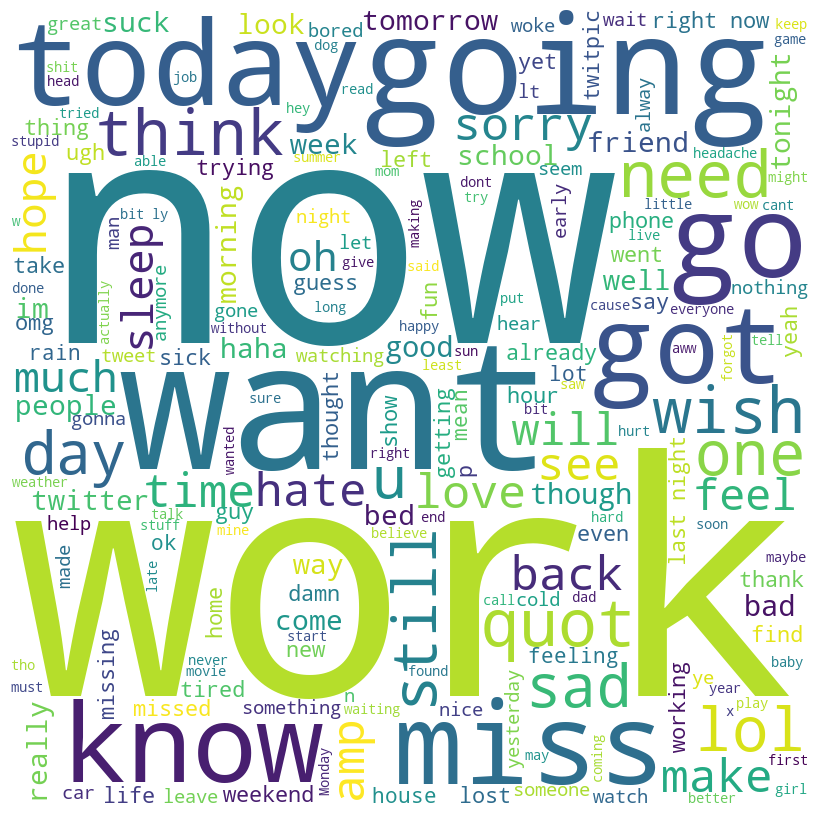

In [6]:
depressive_words = " ".join(list(raw_data[raw_data['target'] == 1]['text']))

dep_words_cloud = WordCloud(width=800, height=800, background_color='white',
                      min_font_size=10).generate(depressive_words)

plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(dep_words_cloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

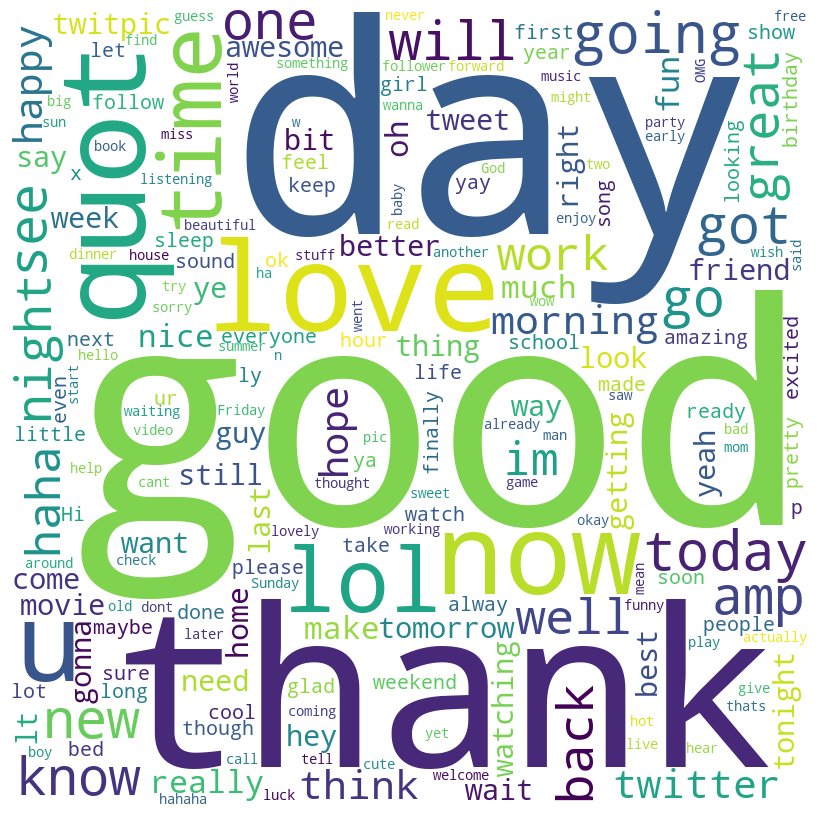

In [7]:

positive_words = " ".join(list(raw_data[raw_data['target'] == 0]['text']))

# Generate Wordcloud
positive_words_cloud = WordCloud(width=800, height=800, background_color='white',
                      min_font_size=10, collocations=False).generate(positive_words)

plt.figure(figsize = (8,8))
plt.imshow(positive_words_cloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## 4. Feature Extraction
### We can clearly see the difference between both the WordClouds. The Former WordCloud (Negative one) shows the presence of depressive and negative words. 
### We will do this in 2 steps:
1. First, we will apply Regex, remove Stopwords, apply PorterStemmer Algorithm and some other basic Processing on the data.


In [8]:
# created a helper function to save ourself from redundant work

def process_text(text):
    """
    @param: text (Raw Text sentence)
    @return: final_str (Final processed string)
    
    Function -> It takes raw string as an Input and processed data to get important features extracted
                First it converts to lower, then applies regex code, then tokenizes the words, then removes
                stopwords, then stems the words, then puts the output list back into a string.
    """
    
    # Convert text to lower and remove all special characters from it using regex
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    
    # Tokenize the words using the word_tokenize() from nltk lib
    words = word_tokenize(text)
    
    # Only take the words whose length is greater than 2
    words = [w for w in words if len(w) > 2]
    
    # Get the stopwords for english language
    sw = stopwords.words('english')
    
    # Get only those words which are not in stopwords (those which are not stopwords)
    words = [word for word in words if word not in sw]
    
    # Get the PorterStemmer algorithm module
    stemmer = PorterStemmer()
    
    # Take the words with commoner morphological and inflexional endings from words removed
    words = [stemmer.stem(word) for word in words]
    
    # Till this point, we have a list of strings (words), we want them to be converted to a string of text
    final_str = ""
    for w in words:
        final_str += w
        final_str += " "
    
    # Return the final string
    return final_str

In [9]:
%%time
# Let's apply this to our data and export it into a '.csv' file
raw_data['text'] = raw_data['text'].apply(process_text)
raw_data.to_csv('feature_extracted.csv', index=False)

CPU times: total: 11min 34s
Wall time: 11min 35s


In [11]:
raw_data.head()

,target,text
0,1,upset cant updat facebook text might cri resul...
1,1,kenichan dive mani time ball manag save rest b...
2,1,whole bodi feel itchi like fire
3,1,nationwideclass behav mad cant see
4,1,kwesidei whole crew
